In [ ]:
import pandas as pd
from datetime import datetime

# Load the current S&P 500 constituents from Wikipedia
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
tables = pd.read_html(url)
earnings_data = tables[0]  # The first table contains the current constituents


In [ ]:
earnings_data.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [ ]:

# Extract the year from the 'Date first added' column
earnings_data['Year added'] = earnings_data['Date added'].str.extract(r'(\d{4})', expand=False)
earnings_data = earnings_data.dropna(subset=['Year added'])  # Remove entries where year couldn't be extracted
earnings_data['Year added'] = df['Year added'].astype(int)

# Calculate the number of additions per year, excluding 1957
additions_per_year = df[df['Year added'] != 1957]['Year added'].value_counts().reset_index()
additions_per_year.columns = ['Year', 'Count']

# Determine the year with the highest additions (most recent in case of a tie)
max_count = additions_per_year['Count'].max()
candidates = additions_per_year[additions_per_year['Count'] == max_count]
answer_year = candidates['Year'].max()

print(f"The year with the highest number of additions (excluding 1957) is: {answer_year}")

# Calculate the number of companies in the index for more than 20 years
current_year = datetime.now().year
df['Years in index'] = current_year - df['Year added']
count_over_20 = (df['Years in index'] > 20).sum()

print(f"Number of current S&P 500 stocks in the index for more than 20 years: {count_over_20}")

The year with the highest number of additions (excluding 1957) is: 2017
Number of current S&P 500 stocks in the index for more than 20 years: 219


# 2 Comparison to index

In [52]:
import yfinance as yf
from datetime import datetime
from dateutil.relativedelta import relativedelta

# 1) Your list of tickers and labels
indices = [
    ('^GSPC', 'United States'),
    ('000001.SS', 'China'),
    ('^HSI', 'Hong Kong'),
    ('^AXJO', 'Australia'),
    ('^NSEI', 'India'),
    ('^GSPTSE', 'Canada'),
    ('^GDAXI', 'Germany'),
    ('^FTSE', 'United Kingdom'),
    ('^N225', 'Japan'),
    ('^MXX', 'Mexico'),
    ('^BVSP', 'Brazil')
]

def calculate_return(symbol, start_date, end_date):
    """
    Downloads the Close prices and returns a Python float for:
      (last_close / first_close - 1) * 100
    or None if data is missing.
    """
    df = yf.download(symbol, start=start_date, end=end_date, progress=False)
    if df.empty:
        return None
    # grab the first and last closing price
    first = df['Close'].iloc[0]
    last  = df['Close'].iloc[-1]
    # compute and force to float
    return float((last.iloc[0] / first.iloc[0] - 1) * 100)

# 2) Define your horizons: YTD plus integer years
horizons = {
    'YTD':   ('2025-01-01', '2025-05-02'),
    '1Y':    None,   # will fill in loop
    '3Y':    None,
    '5Y':    None,
    '10Y':   None
}

# 3) End date is always May 2 so that 2025-05-01 is included
end_date = '2025-05-02'
as_of    = datetime(2025, 5, 1)

# 4) Fill in the date ranges for the multi-year horizons
for label in ['1Y','3Y','5Y','10Y']:
    years = int(label.replace('Y',''))
    start = (as_of - relativedelta(years=years)).strftime('%Y-%m-%d')
    horizons[label] = (start, end_date)

# 5) Compute all returns
all_returns = {label: {} for label in horizons}

for label, (start, end) in horizons.items():
    for ticker, country in indices:
        ret = calculate_return(ticker, start, end)
        all_returns[label][country] = ret

# 6) Compare each horizon to the S&P 500
for label in horizons:
    us_ret = all_returns[label]['United States']
    # sanity-check:
    print(f"\n[{label}] S&P 500 return = {us_ret!r}  (type: {type(us_ret)})")
    
    # build list of outperformers
    beats = []
    for country, r in all_returns[label].items():
        if country == 'United States' or r is None or us_ret is None:
            continue
        # now both r and us_ret should be floats
        if r > us_ret:
            beats.append((country, r))
    
    print(f"Number beating S&P 500: {len(beats)}")
    for country, r in sorted(beats, key=lambda x: x[1], reverse=True):
        print(f"  {country:<12} {r:6.2f}%")




[YTD] S&P 500 return = -4.5055367470435925  (type: <class 'float'>)
Number beating S&P 500: 9
  Mexico        13.05%
  Hong Kong     12.72%
  Brazil        12.44%
  Germany       12.35%
  United Kingdom   2.87%
  India          2.49%
  China          0.50%
  Canada        -0.41%
  Australia     -0.68%

[1Y] S&P 500 return = 11.672069808087704  (type: <class 'float'>)
Number beating S&P 500: 3
  Germany       25.71%
  Hong Kong     21.49%
  Canada        14.12%

[3Y] S&P 500 return = 34.864688542643684  (type: <class 'float'>)
Number beating S&P 500: 3
  Germany       61.40%
  India         42.56%
  Japan         35.92%

[5Y] S&P 500 return = 97.9764869609856  (type: <class 'float'>)
Number beating S&P 500: 2
  India        161.84%
  Germany      114.94%

[10Y] S&P 500 return = 165.81447679801974  (type: <class 'float'>)
Number beating S&P 500: 1
  India        192.06%


In [66]:
sp500

Ticker,^GSPC
Date,
1950-01-03,16.660000
1950-01-04,16.850000
1950-01-05,16.930000
1950-01-06,16.980000
1950-01-09,17.080000
...,...
2025-05-21,5844.609863
2025-05-22,5842.009766
2025-05-23,5802.819824


In [68]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
# Download S&P 500 data from 1950 to present
print("Downloading S&P 500 historical data...")
sp500_data = yf.download("^GSPC", start="1950-01-01", end=datetime.now().strftime("%Y-%m-%d"))
sp500_close = sp500_data['Close'].dropna()

print(f"Data downloaded: {len(sp500_close)} trading days from {sp500_close.index[0].strftime('%Y-%m-%d')} to {sp500_close.index[-1].strftime('%Y-%m-%d')}")

# Calculate running maximum (all-time highs)
sp500_df = pd.DataFrame(index=sp500_close.index)
sp500_df['Close'] = sp500_close
sp500_df['Running_Max'] = sp500_close.expanding().max()

[*********************100%***********************]  1 of 1 completed

Data downloaded: 18971 trading days from 1950-01-03 to 2025-05-28


In [69]:
sp500_df

,Close,Running_Max
Date,,
1950-01-03,16.660000,16.660000
1950-01-04,16.850000,16.850000
1950-01-05,16.930000,16.930000
1950-01-06,16.980000,16.980000
1950-01-09,17.080000,17.080000
...,...,...
2025-05-21,5844.609863,6144.149902
2025-05-22,5842.009766,6144.149902
2025-05-23,5802.819824,6144.149902


Found 1474 all-time high points

Found 72 corrections >= 5%

Top 10 largest corrections by drawdown:
2007-10-09 to 2009-03-09: 56.8% drawdown over 517 days
2000-03-24 to 2002-10-09: 49.1% drawdown over 929 days
1973-01-11 to 1974-10-03: 48.2% drawdown over 630 days
1968-11-29 to 1970-05-26: 36.1% drawdown over 543 days
2020-02-19 to 2020-03-23: 33.9% drawdown over 33 days
1987-08-25 to 1987-12-04: 33.5% drawdown over 101 days
1961-12-12 to 1962-06-26: 28.0% drawdown over 196 days
1980-11-28 to 1982-08-12: 27.1% drawdown over 622 days
2022-01-03 to 2022-10-12: 25.4% drawdown over 282 days
1966-02-09 to 1966-10-07: 22.2% drawdown over 240 days

CORRECTION DURATION STATISTICS
Total corrections analyzed: 72
25th percentile: 22 days
50th percentile (median): 40 days
75th percentile: 88 days
Mean duration: 112 days
Standard deviation: 177 days
Minimum duration: 7 days
Maximum duration: 929 days

DRAWDOWN STATISTICS
Average drawdown: 12.7%
Median drawdown: 8.0%
Largest drawdown: 56.8%
Smalles

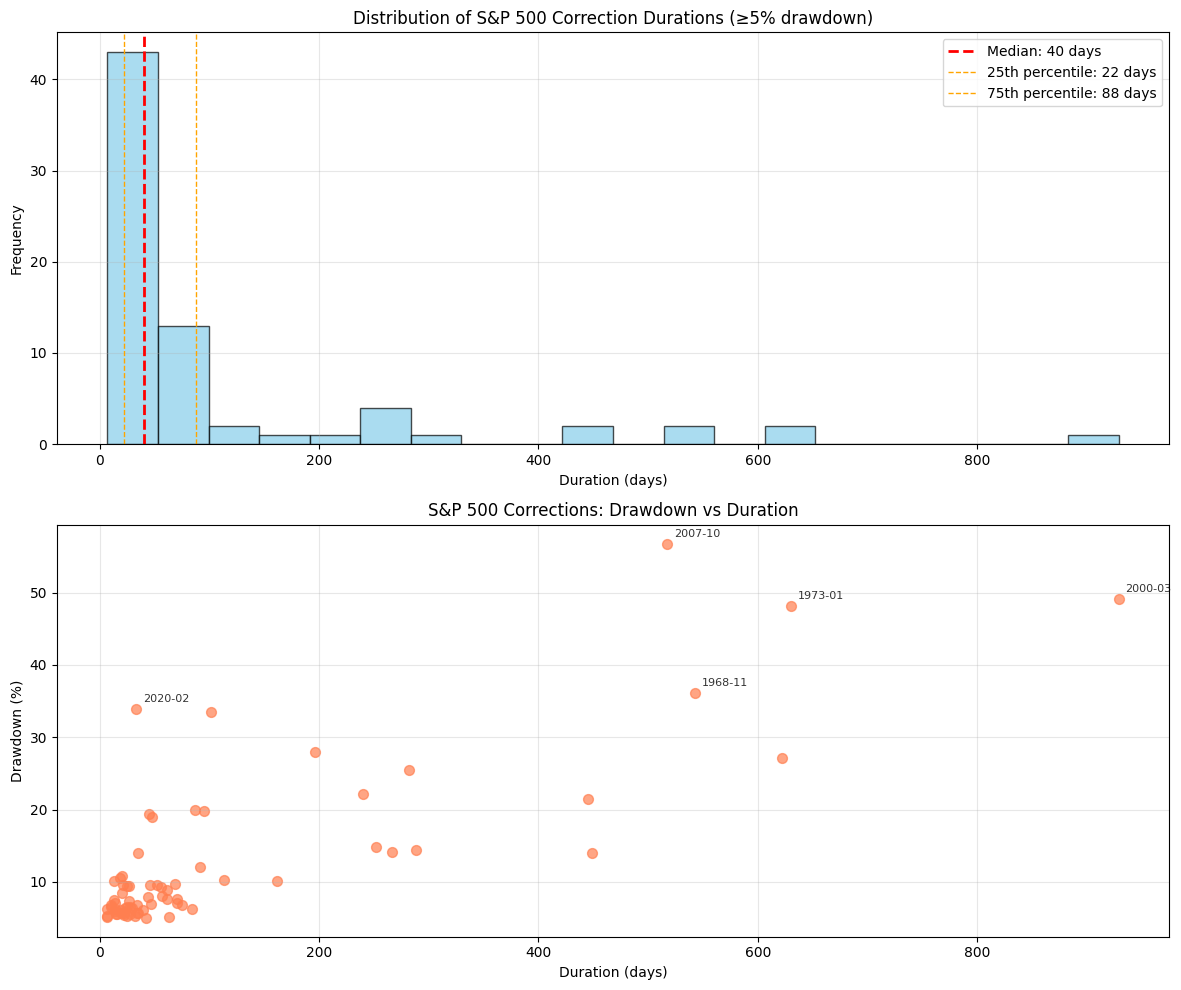


DETAILED CORRECTIONS LIST
Start_Date   End_Date  Start_Price  Min_Price  Drawdown_Pct  Duration_Days
2007-10-09 2009-03-09      1565.15     676.53          56.8            517
2000-03-24 2002-10-09      1527.46     776.76          49.1            929
1973-01-11 1974-10-03       120.24      62.28          48.2            630
1968-11-29 1970-05-26       108.37      69.29          36.1            543
2020-02-19 2020-03-23      3386.15    2237.40          33.9             33
1987-08-25 1987-12-04       336.77     223.92          33.5            101
1961-12-12 1962-06-26        72.64      52.32          28.0            196
1980-11-28 1982-08-12       140.52     102.42          27.1            622
2022-01-03 2022-10-12      4796.56    3577.03          25.4            282
1966-02-09 1966-10-07        94.06      73.20          22.2            240
1956-08-03 1957-10-22        49.64      38.98          21.5            445
1990-07-16 1990-10-11       368.95     295.46          19.9             8

In [70]:
# Calculate drawdown from all-time high
sp500_df['Drawdown_Pct'] = (sp500_df['Running_Max'] - sp500_df['Close']) / sp500_df['Running_Max'] * 100

# Identify all-time high points (where current price equals running max)
sp500_df['Is_ATH'] = sp500_df['Close'] == sp500_df['Running_Max']

# Get all-time high dates
ath_dates = sp500_df[sp500_df['Is_ATH']].index.tolist()
print(f"Found {len(ath_dates)} all-time high points")

# Find corrections between consecutive all-time highs
corrections = []

for i in range(len(ath_dates) - 1):
    start_date = ath_dates[i]
    end_date = ath_dates[i + 1]
    
    # Get data between consecutive ATHs
    period_data = sp500_df.loc[start_date:end_date]
    
    # Find the minimum price in this period
    min_idx = period_data['Close'].idxmin()
    min_price = period_data['Close'].min()
    start_price = period_data.iloc[0]['Close']
    
    # Calculate drawdown
    drawdown_pct = (start_price - min_price) / start_price * 100
    
    # Only include corrections >= 5%
    if drawdown_pct >= 5.0:
        # Calculate duration in days
        duration_days = (min_idx - start_date).days
        
        corrections.append({
            'Start_Date': start_date,
            'End_Date': min_idx,  # End at the bottom of the correction
            'Start_Price': start_price,
            'Min_Price': min_price,
            'Drawdown_Pct': drawdown_pct,
            'Duration_Days': duration_days
        })

# Handle the final period (from last ATH to present)
if len(ath_dates) > 0:
    last_ath = ath_dates[-1]
    final_period = sp500_df.loc[last_ath:]
    
    if len(final_period) > 1:
        min_idx = final_period['Close'].idxmin()
        min_price = final_period['Close'].min()
        start_price = final_period.iloc[0]['Close']
        drawdown_pct = (start_price - min_price) / start_price * 100
        
        if drawdown_pct >= 5.0:
            duration_days = (min_idx - last_ath).days
            corrections.append({
                'Start_Date': last_ath,
                'End_Date': min_idx,
                'Start_Price': start_price,
                'Min_Price': min_price,
                'Drawdown_Pct': drawdown_pct,
                'Duration_Days': duration_days
            })

# Convert to DataFrame
corrections_df = pd.DataFrame(corrections)
corrections_df = corrections_df.sort_values('Drawdown_Pct', ascending=False)

print(f"\nFound {len(corrections_df)} corrections >= 5%")
print(f"\nTop 10 largest corrections by drawdown:")
print("=" * 80)

for i, row in corrections_df.head(10).iterrows():
    print(f"{row['Start_Date'].strftime('%Y-%m-%d')} to {row['End_Date'].strftime('%Y-%m-%d')}: "
          f"{row['Drawdown_Pct']:.1f}% drawdown over {row['Duration_Days']} days")

# Calculate duration statistics
durations = corrections_df['Duration_Days'].values
percentiles = np.percentile(durations, [25, 50, 75])

print(f"\n" + "=" * 80)
print(f"CORRECTION DURATION STATISTICS")
print(f"=" * 80)
print(f"Total corrections analyzed: {len(corrections_df)}")
print(f"25th percentile: {percentiles[0]:.0f} days")
print(f"50th percentile (median): {percentiles[1]:.0f} days")
print(f"75th percentile: {percentiles[2]:.0f} days")
print(f"Mean duration: {np.mean(durations):.0f} days")
print(f"Standard deviation: {np.std(durations):.0f} days")
print(f"Minimum duration: {np.min(durations):.0f} days")
print(f"Maximum duration: {np.max(durations):.0f} days")

# Additional statistics
print(f"\n" + "=" * 80)
print(f"DRAWDOWN STATISTICS")
print(f"=" * 80)
drawdowns = corrections_df['Drawdown_Pct'].values
print(f"Average drawdown: {np.mean(drawdowns):.1f}%")
print(f"Median drawdown: {np.median(drawdowns):.1f}%")
print(f"Largest drawdown: {np.max(drawdowns):.1f}%")
print(f"Smallest drawdown: {np.min(drawdowns):.1f}%")

# Create visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Duration histogram
ax1.hist(durations, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
ax1.axvline(percentiles[1], color='red', linestyle='--', linewidth=2, label=f'Median: {percentiles[1]:.0f} days')
ax1.axvline(percentiles[0], color='orange', linestyle='--', linewidth=1, label=f'25th percentile: {percentiles[0]:.0f} days')
ax1.axvline(percentiles[2], color='orange', linestyle='--', linewidth=1, label=f'75th percentile: {percentiles[2]:.0f} days')
ax1.set_xlabel('Duration (days)')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of S&P 500 Correction Durations (≥5% drawdown)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Drawdown vs Duration scatter plot
ax2.scatter(corrections_df['Duration_Days'], corrections_df['Drawdown_Pct'], 
           alpha=0.7, color='coral', s=50)
ax2.set_xlabel('Duration (days)')
ax2.set_ylabel('Drawdown (%)')
ax2.set_title('S&P 500 Corrections: Drawdown vs Duration')
ax2.grid(True, alpha=0.3)

# Annotate some major corrections
major_corrections = corrections_df.head(5)
for i, row in major_corrections.iterrows():
    ax2.annotate(f"{row['Start_Date'].strftime('%Y-%m')}",
                xy=(row['Duration_Days'], row['Drawdown_Pct']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=8, alpha=0.8)

plt.tight_layout()
plt.show()

# Export detailed results
print(f"\n" + "=" * 80)
print(f"DETAILED CORRECTIONS LIST")
print(f"=" * 80)
corrections_display = corrections_df.copy()
corrections_display['Start_Date'] = corrections_display['Start_Date'].dt.strftime('%Y-%m-%d')
corrections_display['End_Date'] = corrections_display['End_Date'].dt.strftime('%Y-%m-%d')
corrections_display = corrections_display.round({'Drawdown_Pct': 1, 'Start_Price': 2, 'Min_Price': 2})

print(corrections_display.to_string(index=False))

print(f"\n" + "=" * 80)
print(f"KEY FINDINGS")
print(f"=" * 80)
print(f"• The median duration of S&P 500 corrections (≥5%) is {percentiles[1]:.0f} days")
print(f"• 50% of corrections last between {percentiles[0]:.0f} and {percentiles[2]:.0f} days")
print(f"• The average correction lasts {np.mean(durations):.0f} days")
print(f"• Corrections range from {np.min(durations):.0f} to {np.max(durations):.0f} days")
print(f"• The average drawdown during corrections is {np.mean(drawdowns):.1f}%")

# q3 amazon stock analysis:

In [39]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Load earnings data
import pandas as pd

# Load the data with semicolon separator
file_path = "ha1_Amazon.csv"
earnings_data = pd.read_csv(file_path, sep=';')

# Convert 'Earnings Date' column to datetime, with coercion for errors
earnings_data['Earnings Date'] = pd.to_datetime(earnings_data['Earnings Date'], errors='coerce')

# Define a function to try parsing float values, otherwise return NaN
def try_parse_float(value):
    try:
        return float(value)
    except (ValueError, TypeError):
        return pd.NA  # Or numpy.nan if you prefer

# Apply parsing to the relevant columns
for col in ['EPS Estimate', 'Reported EPS', 'Surprise (%)']:
    earnings_data[col] = earnings_data[col].apply(try_parse_float)

# Optionally, convert to pandas nullable float dtype for better NaN handling
earnings_data = earnings_data.astype({
    'EPS Estimate': 'Float64',
    'Reported EPS': 'Float64',
    'Surprise (%)': 'Float64'
})

# Check the cleaned data
print(earnings_data.head(10))


  Symbol           Company       Earnings Date  EPS Estimate  Reported EPS  \
0   AMZN    Amazon.com Inc 2026-04-29 06:00:00          <NA>          <NA>   
1   AMZN    Amazon.com Inc                 NaT          <NA>          <NA>   
2   AMZN    Amazon.com Inc 2025-10-29 06:00:00          <NA>          <NA>   
3   AMZN    Amazon.com Inc 2025-07-30 16:00:00          <NA>          <NA>   
4   AMZN  Amazon.com, Inc. 2025-05-01 16:00:00          <NA>          <NA>   
5   AMZN  Amazon.com, Inc.                 NaT          <NA>          <NA>   
6   AMZN  Amazon.com, Inc. 2024-10-31 16:00:00          <NA>          <NA>   
7   AMZN  Amazon.com, Inc. 2024-08-01 16:00:00          <NA>          <NA>   
8   AMZN  Amazon.com, Inc. 2024-04-30 16:00:00          0.83          0.98   
9   AMZN  Amazon.com, Inc.                 NaT           0.8           1.0   

   Surprise (%)  
0          <NA>  
1          <NA>  
2          <NA>  
3          <NA>  
4         16.74  
5         24.47  
6         25.17

In [40]:
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import numpy as np

# Step 1: Load and clean earnings data
df_earnings = pd.read_csv('ha1_Amazon.csv', sep=';', skipfooter=1, engine='python')

# Clean the Surprise (%) column
def clean_surprise(value):
    if isinstance(value, str):
        value = value.replace('%', '').replace('?', '').replace(',', '.').strip()
        if value == '-' or value == '':
            return None
        try:
            return float(value)
        except ValueError:
            return None
    return value

df_earnings['Surprise (%)'] = df_earnings['Surprise (%)'].apply(clean_surprise)
df_earnings = df_earnings.dropna(subset=['Surprise (%)'])
df_earnings['Surprise (%)'] = df_earnings['Surprise (%)'].astype(float)

# Parse the date column
def parse_date(date_str):
    date_part = date_str.split(' at ')[0].strip()
    return datetime.strptime(date_part, "%B %d, %Y").date()

df_earnings['Earnings Date'] = df_earnings['Earnings Date'].apply(parse_date)

# Filter for positive surprises
positive_earnings = df_earnings[df_earnings['Surprise (%)'] > 0].copy()

# Step 2: Download historical prices
ticker = 'AMZN'
stock_data = yf.download(ticker, start='1997-01-01', end=datetime.today().strftime('%Y-%m-%d'))
stock_data.index = stock_data.index.date

# Step 3: Precompute 2-day returns
# Calculate 2-day returns: (Close of day t+2) / (Close of day t) - 1
stock_data['two_day_return'] = (stock_data['Close'].shift(-2) / stock_data['Close']) - 1

# Step 4: Identify valid earnings events and get returns
event_returns = []
surprises = []
skipped_dates = []

for idx, row in positive_earnings.iterrows():
    event_date = row['Earnings Date']
    
    # Adjust to next trading day if not in index
    if event_date not in stock_data.index:
        next_dates = stock_data[stock_data.index > event_date]
        if next_dates.empty:
            skipped_dates.append((event_date, "No future trading days"))
            continue
        adjusted_date = next_dates.index[0]
    else:
        adjusted_date = event_date
    
    # Find position of adjusted_date in the index
    if adjusted_date not in stock_data.index:
        skipped_dates.append((event_date, "Adjusted date not found"))
        continue
    
    pos = stock_data.index.get_loc(adjusted_date)
    if pos == 0 or pos >= len(stock_data.index) - 2:
        skipped_dates.append((event_date, "Insufficient trading days before or after"))
        continue
    
    # Get return using integer-based indexing
    event_return = stock_data['two_day_return'].iloc[pos-1]
    
    if pd.isna(event_return):
        skipped_dates.append((event_date, "Missing return data"))
        continue
    
    event_returns.append(event_return)
    surprises.append(row['Surprise (%)'])

# Step 5: Compute medians and correlation
median_all = stock_data['two_day_return'].median()
median_positive = pd.Series(event_returns).median()

# Correlation calculation (only if we have events)
if len(event_returns) > 1:
    correlation = pd.Series(event_returns).corr(pd.Series(surprises))
else:
    correlation = np.nan

print(f"Median 2-day return for all historical periods: {median_all:.4f}")
print(f"Median 2-day return following positive earnings surprises: {median_positive:.4f}")
print(f"Number of positive earnings events analyzed: {len(event_returns)}")
print(f"Correlation between surprise magnitude and 2-day return: {correlation:.4f}")

# Optional: Print skipped dates for debugging
if skipped_dates:
    print("\nSkipped dates:")
    for date, reason in skipped_dates:
        print(f"{date}: {reason}")

[*********************100%***********************]  1 of 1 completed

Median 2-day return for all historical periods: 0.0017
Median 2-day return following positive earnings surprises: 0.0104
Number of positive earnings events analyzed: 86
Correlation between surprise magnitude and 2-day return: 0.2244


In [42]:
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import numpy as np

# Step 1: Load and clean earnings data
df_earnings = pd.read_csv('ha1_Amazon.csv', sep=';', skipfooter=1, engine='python')

# Clean the Surprise (%) column
def clean_surprise(value):
    if isinstance(value, str):
        value = value.replace('%', '').replace('?', '').replace(',', '.').strip()
        if value == '-' or value == '':
            return None
        try:
            return float(value)
        except ValueError:
            return None
    return value

df_earnings['Surprise (%)'] = df_earnings['Surprise (%)'].apply(clean_surprise)
df_earnings = df_earnings.dropna(subset=['Surprise (%)'])
df_earnings['Surprise (%)'] = df_earnings['Surprise (%)'].astype(float)

# Parse the date column
def parse_date(date_str):
    date_part = date_str.split(' at ')[0].strip()
    return datetime.strptime(date_part, "%B %d, %Y").date()

df_earnings['Earnings Date'] = df_earnings['Earnings Date'].apply(parse_date)

# Filter for positive surprises
positive_earnings = df_earnings[df_earnings['Surprise (%)'] > 0].copy()

# Step 2: Download historical prices
ticker = 'AMZN'
stock_data = yf.download(ticker, start='1997-01-01', end=datetime.today().strftime('%Y-%m-%d'))
stock_data.index = stock_data.index.date

# Step 3: Precompute 2-day returns
# Calculate 2-day returns: (Close of day t+2) / (Close of day t) - 1
stock_data['two_day_return'] = (stock_data['Close'].shift(-2) / stock_data['Close']) - 1

# Step 4: Identify valid earnings events and get returns
event_returns = []
surprises = []
skipped_dates = []

for idx, row in positive_earnings.iterrows():
    event_date = row['Earnings Date']
    
    # Adjust to next trading day if not in index
    if event_date not in stock_data.index:
        next_dates = stock_data[stock_data.index > event_date]
        if next_dates.empty:
            skipped_dates.append((event_date, "No future trading days"))
            continue
        adjusted_date = next_dates.index[0]
    else:
        adjusted_date = event_date
    
    # Find position of adjusted_date in the index
    if adjusted_date not in stock_data.index:
        skipped_dates.append((event_date, "Adjusted date not found"))
        continue
    
    pos = stock_data.index.get_loc(adjusted_date)
    if pos == 0 or pos >= len(stock_data.index) - 2:
        skipped_dates.append((event_date, "Insufficient trading days before or after"))
        continue
    
    # Get return using integer-based indexing
    event_return = stock_data['two_day_return'].iloc[pos-1]
    
    if pd.isna(event_return):
        skipped_dates.append((event_date, "Missing return data"))
        continue
    
    event_returns.append(event_return)
    surprises.append(row['Surprise (%)'])

# Step 5: Compute medians and correlation
median_all = stock_data['two_day_return'].median()
median_positive = pd.Series(event_returns).median()

# Correlation calculation (only if we have events)
if len(event_returns) > 1:
    correlation = pd.Series(event_returns).corr(pd.Series(surprises))
else:
    correlation = np.nan

print(f"Median 2-day return for all historical periods: {median_all:.4f}")
print(f"Median 2-day return following positive earnings surprises: {median_positive:.4f}")
print(f"Number of positive earnings events analyzed: {len(event_returns)}")
print(f"Correlation between surprise magnitude and 2-day return: {correlation:.4f}")

# Optional: Print skipped dates for debugging
if skipped_dates:
    print("\nSkipped dates:")
    for date, reason in skipped_dates:
        print(f"{date}: {reason}")

[*********************100%***********************]  1 of 1 completed

Median 2-day return for all historical periods: 0.0017
Median 2-day return following positive earnings surprises: 0.0104
Number of positive earnings events analyzed: 86
Correlation between surprise magnitude and 2-day return: 0.2244


## detailed analysis

In [36]:

# Download Amazon stock price data
print("\nDownloading Amazon stock price data...")
amzn_data = yf.download("AMZN", start="1997-01-01", end=datetime.now().strftime("%Y-%m-%d"))
amzn_close = amzn_data['Close'].dropna()

print(f"Stock data downloaded: {len(amzn_close)} trading days from {amzn_close.index[0].strftime('%Y-%m-%d')} to {amzn_close.index[-1].strftime('%Y-%m-%d')}")

# Calculate 2-day percentage changes for all historical dates
print("\nCalculating 2-day percentage changes for all dates...")
price_df = pd.DataFrame(index=amzn_close.index)
price_df['Close'] = amzn_close

# Calculate 2-day returns: (Close_Day3 / Close_Day1) - 1
price_df['Close_2days_ahead'] = price_df['Close'].shift(-2)
price_df['Return_2day'] = (price_df['Close_2days_ahead'] / price_df['Close']) - 1

# Remove NaN values
price_df = price_df.dropna()
all_2day_returns = price_df['Return_2day'].dropna()

print(f"Total 2-day returns calculated: {len(all_2day_returns)}")

# Process earnings data
print("\nProcessing earnings data...")

# Try to identify the date column and convert to datetime
date_columns = [col for col in earnings_data.columns if 'date' in col.lower() or 'Date' in col]
if date_columns:
    date_col = date_columns[0]
    print(f"Using date column: {date_col}")
else:
    # Try the first column if no obvious date column
    date_col = earnings_data.columns[0]
    print(f"Assuming first column is date: {date_col}")

# Convert date column to datetime
earnings_data[date_col] = pd.to_datetime(earnings_data[date_col], errors='coerce')
earnings_data = earnings_data.dropna(subset=[date_col])

# Identify EPS columns
eps_actual_cols = [col for col in earnings_data.columns if 'actual' in col.lower() and 'eps' in col.lower()]
eps_estimate_cols = [col for col in earnings_data.columns if 'estimate' in col.lower() and 'eps' in col.lower()]
surprise_cols = [col for col in earnings_data.columns if 'surprise' in col.lower()]

print(f"EPS Actual columns found: {eps_actual_cols}")
print(f"EPS Estimate columns found: {eps_estimate_cols}")
print(f"Surprise columns found: {surprise_cols}")

# Use the first available columns or create them
if eps_actual_cols:
    actual_col = eps_actual_cols[0]
else:
    actual_col = None
    
if eps_estimate_cols:
    estimate_col = eps_estimate_cols[0]
else:
    estimate_col = None

if surprise_cols:
    surprise_col = surprise_cols[0]
else:
    surprise_col = None

# If we don't have actual and estimate columns, try to find them by other names
if not actual_col:
    potential_actual = [col for col in earnings_data.columns if 'actual' in col.lower() or 'reported' in col.lower()]
    if potential_actual:
        actual_col = potential_actual[0]
        
if not estimate_col:
    potential_estimate = [col for col in earnings_data.columns if 'estimate' in col.lower() or 'consensus' in col.lower() or 'expected' in col.lower()]
    if potential_estimate:
        estimate_col = potential_estimate[0]

print(f"\nUsing columns:")
print(f"Date: {date_col}")
print(f"Actual EPS: {actual_col}")
print(f"Estimate EPS: {estimate_col}")
print(f"Surprise: {surprise_col}")


[*********************100%***********************]  1 of 1 completed


Stock data downloaded: 7053 trading days from 1997-05-15 to 2025-05-28

Calculating 2-day percentage changes for all dates...
Total 2-day returns calculated: 7051

Processing earnings data...
Using date column: Earnings Date
EPS Actual columns found: []
EPS Estimate columns found: ['EPS Estimate']
Surprise columns found: ['Surprise (%)']

Using columns:
Date: Earnings Date
Actual EPS: Reported EPS
Estimate EPS: EPS Estimate
Surprise: Surprise (%)


In [37]:

# Calculate surprise if not available
if not surprise_col and actual_col and estimate_col:
    earnings_data['Calculated_Surprise_Pct'] = ((earnings_data[actual_col] - earnings_data[estimate_col]) / abs(earnings_data[estimate_col])) * 100
    surprise_col = 'Calculated_Surprise_Pct'
    print("Calculated surprise percentage from actual vs estimate EPS")

# Identify positive earnings surprises
positive_surprises = []

if surprise_col:
    # Method 1: Using surprise percentage > 0
    positive_mask = earnings_data[surprise_col] > 0
    positive_surprises_df = earnings_data[positive_mask].copy()
    print(f"Found {len(positive_surprises_df)} positive surprises using surprise column")
elif actual_col and estimate_col:
    # Method 2: Using actual > estimate
    positive_mask = earnings_data[actual_col] > earnings_data[estimate_col]
    positive_surprises_df = earnings_data[positive_mask].copy()
    print(f"Found {len(positive_surprises_df)} positive surprises using actual > estimate")
else:
    print("Error: Cannot identify positive surprises - missing required columns")
    exit()


Found 61 positive surprises using surprise column



Matching earnings dates with stock price data...
Successfully matched 61 earnings dates with stock returns

EARNINGS SURPRISE ANALYSIS RESULTS
Total positive earnings surprises analyzed: 61
Median 2-day return after positive surprises: -0.17%
Median 2-day return for all historical dates: 0.17%
Difference (surprise premium): -0.34%

DETAILED STATISTICS:
Positive Surprises - Mean: 1.12%
Positive Surprises - Std: 12.33%
Positive Surprises - Min: -28.20%
Positive Surprises - Max: 40.29%
All Returns - Mean: 0.34%
All Returns - Std: 4.98%

STATISTICAL TEST:
T-statistic: 0.675
P-value: 0.500
Statistically significant difference: No

CORRELATION ANALYSIS:
Correlation between surprise magnitude and 2-day return: 0.058
Correlation p-value: 0.659
Significant correlation: No


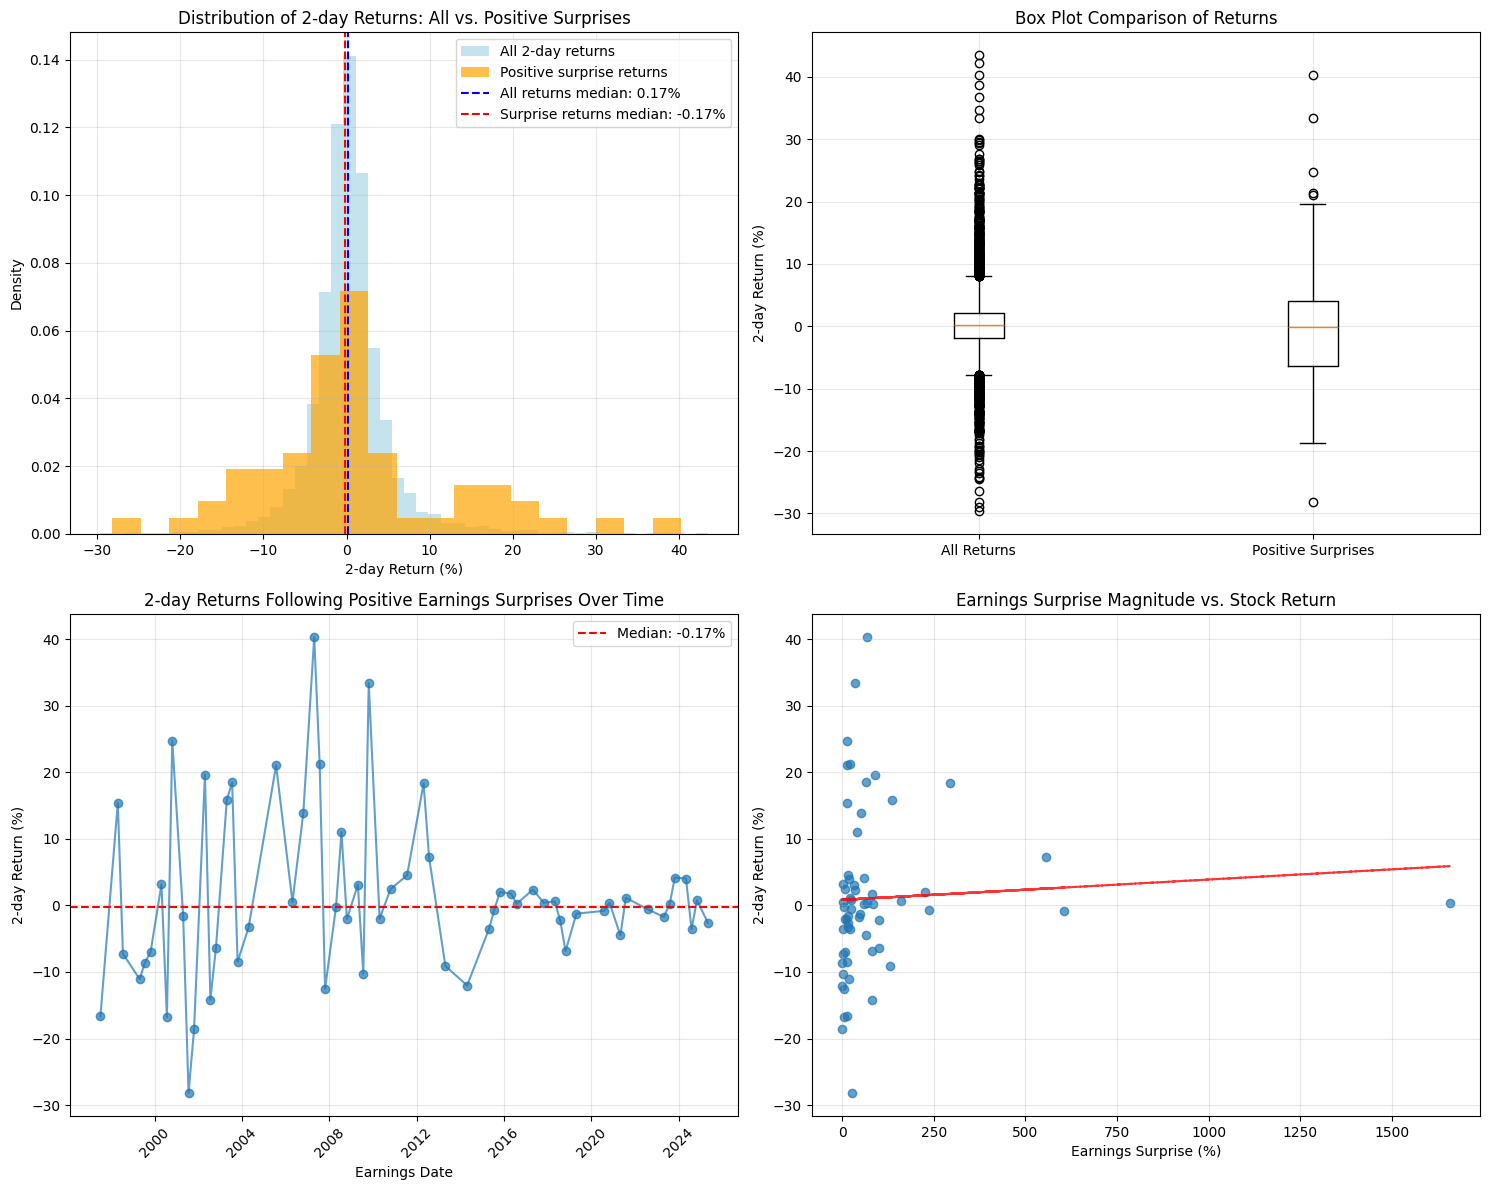


RECENT POSITIVE EARNINGS SURPRISES
earnings_date trading_date return_2day surprise_pct actual_eps estimate_eps
   2021-04-29   2021-04-30      -4.49%        65.5%       0.79         0.48
   2021-07-29   2021-07-30       1.16%        22.9%       0.76         0.62
   2022-07-28   2022-07-29      -0.59%        24.9%       0.18         0.14
   2023-04-27   2023-04-28      -1.73%        46.4%       0.31         0.21
   2023-08-03   2023-08-04       0.27%        85.7%       0.65         0.35
   2023-10-26   2023-10-27       4.19%        60.9%       0.94         0.58
   2024-04-30   2024-05-01       4.03%        17.9%       0.98         0.83
   2024-08-01   2024-08-02      -3.56%        22.6%       <NA>         <NA>
   2024-10-31   2024-11-01       0.79%        25.2%       <NA>         <NA>
   2025-05-01   2025-05-02      -2.62%        16.7%       <NA>         <NA>

KEY FINDINGS
• Amazon stock shows underperformance following positive earnings surprises
• Median 2-day return after positive s

In [38]:

# Match earnings dates with stock price data
print("\nMatching earnings dates with stock price data...")
earnings_returns = []

for idx, row in positive_surprises_df.iterrows():
    earnings_date = row[date_col]
    
    # Find the closest trading day on or after the earnings date
    available_dates = price_df.index[price_df.index >= earnings_date]
    
    if len(available_dates) > 0:
        closest_date = available_dates[0]
        
        # Get the 2-day return starting from this date
        if closest_date in price_df.index:
            return_2day = price_df.loc[closest_date, 'Return_2day']
            
            if not pd.isna(return_2day):
                surprise_value = row[surprise_col] if surprise_col else None
                earnings_returns.append({
                    'earnings_date': earnings_date,
                    'trading_date': closest_date,
                    'return_2day': return_2day,
                    'surprise_pct': surprise_value,
                    'actual_eps': row[actual_col] if actual_col else None,
                    'estimate_eps': row[estimate_col] if estimate_col else None
                })

earnings_returns_df = pd.DataFrame(earnings_returns)
print(f"Successfully matched {len(earnings_returns_df)} earnings dates with stock returns")

if len(earnings_returns_df) == 0:
    print("Error: No earnings dates could be matched with stock price data")
    exit()

# Calculate statistics
positive_surprise_returns = earnings_returns_df['return_2day']
median_positive_surprise_return = positive_surprise_returns.median()
median_all_returns = all_2day_returns.median()

print(f"\n" + "=" * 80)
print(f"EARNINGS SURPRISE ANALYSIS RESULTS")
print(f"=" * 80)
print(f"Total positive earnings surprises analyzed: {len(positive_surprise_returns)}")
print(f"Median 2-day return after positive surprises: {median_positive_surprise_return:.2%}")
print(f"Median 2-day return for all historical dates: {median_all_returns:.2%}")
print(f"Difference (surprise premium): {(median_positive_surprise_return - median_all_returns):.2%}")

# Additional statistics
print(f"\nDETAILED STATISTICS:")
print(f"Positive Surprises - Mean: {positive_surprise_returns.mean():.2%}")
print(f"Positive Surprises - Std: {positive_surprise_returns.std():.2%}")
print(f"Positive Surprises - Min: {positive_surprise_returns.min():.2%}")
print(f"Positive Surprises - Max: {positive_surprise_returns.max():.2%}")
print(f"All Returns - Mean: {all_2day_returns.mean():.2%}")
print(f"All Returns - Std: {all_2day_returns.std():.2%}")

# Statistical significance test
if len(positive_surprise_returns) > 1:
    # Sample from all returns to match the size for fair comparison
    sample_all_returns = np.random.choice(all_2day_returns, size=min(len(positive_surprise_returns) * 10, len(all_2day_returns)), replace=False)
    t_stat, p_value = stats.ttest_ind(positive_surprise_returns, sample_all_returns)
    print(f"\nSTATISTICAL TEST:")
    print(f"T-statistic: {t_stat:.3f}")
    print(f"P-value: {p_value:.3f}")
    print(f"Statistically significant difference: {'Yes' if p_value < 0.05 else 'No'}")

# Correlation analysis (if surprise magnitude is available)
if surprise_col and len(earnings_returns_df) > 5:
    surprise_values = earnings_returns_df['surprise_pct'].dropna()
    corresponding_returns = earnings_returns_df.loc[surprise_values.index, 'return_2day']
    
    if len(surprise_values) > 5:
        correlation, corr_p_value = stats.pearsonr(surprise_values, corresponding_returns)
        print(f"\nCORRELATION ANALYSIS:")
        print(f"Correlation between surprise magnitude and 2-day return: {correlation:.3f}")
        print(f"Correlation p-value: {corr_p_value:.3f}")
        print(f"Significant correlation: {'Yes' if corr_p_value < 0.05 else 'No'}")

# Create visualizations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. Distribution comparison
ax1.hist(all_2day_returns * 100, bins=50, alpha=0.7, label='All 2-day returns', density=True, color='lightblue')
ax1.hist(positive_surprise_returns * 100, bins=20, alpha=0.7, label='Positive surprise returns', density=True, color='orange')
ax1.axvline(median_all_returns * 100, color='blue', linestyle='--', label=f'All returns median: {median_all_returns:.2%}')
ax1.axvline(median_positive_surprise_return * 100, color='red', linestyle='--', label=f'Surprise returns median: {median_positive_surprise_return:.2%}')
ax1.set_xlabel('2-day Return (%)')
ax1.set_ylabel('Density')
ax1.set_title('Distribution of 2-day Returns: All vs. Positive Surprises')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Box plot comparison
box_data = [all_2day_returns * 100, positive_surprise_returns * 100]
box_labels = ['All Returns', 'Positive Surprises']
ax2.boxplot(box_data, labels=box_labels)
ax2.set_ylabel('2-day Return (%)')
ax2.set_title('Box Plot Comparison of Returns')
ax2.grid(True, alpha=0.3)

# 3. Time series of positive surprise returns
if len(earnings_returns_df) > 0:
    earnings_returns_df_sorted = earnings_returns_df.sort_values('earnings_date')
    ax3.plot(earnings_returns_df_sorted['earnings_date'], earnings_returns_df_sorted['return_2day'] * 100, 'o-', alpha=0.7)
    ax3.axhline(median_positive_surprise_return * 100, color='red', linestyle='--', label=f'Median: {median_positive_surprise_return:.2%}')
    ax3.set_xlabel('Earnings Date')
    ax3.set_ylabel('2-day Return (%)')
    ax3.set_title('2-day Returns Following Positive Earnings Surprises Over Time')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)

# 4. Surprise magnitude vs returns (if available)
if surprise_col and len(earnings_returns_df['surprise_pct'].dropna()) > 5:
    surprise_clean = earnings_returns_df['surprise_pct'].dropna()
    returns_clean = earnings_returns_df.loc[surprise_clean.index, 'return_2day'] * 100
    
    ax4.scatter(surprise_clean, returns_clean, alpha=0.7)
    
    # Add trend line
    if len(surprise_clean) > 1:
        z = np.polyfit(surprise_clean, returns_clean, 1)
        p = np.poly1d(z)
        ax4.plot(surprise_clean, p(surprise_clean), "r--", alpha=0.8)
    
    ax4.set_xlabel('Earnings Surprise (%)')
    ax4.set_ylabel('2-day Return (%)')
    ax4.set_title('Earnings Surprise Magnitude vs. Stock Return')
    ax4.grid(True, alpha=0.3)
else:
    ax4.text(0.5, 0.5, 'Surprise magnitude\ndata not available', 
             horizontalalignment='center', verticalalignment='center',
             transform=ax4.transAxes, fontsize=12)
    ax4.set_title('Earnings Surprise Magnitude Analysis')

plt.tight_layout()
plt.show()

# Summary table of recent earnings surprises
print(f"\n" + "=" * 80)
print(f"RECENT POSITIVE EARNINGS SURPRISES")
print(f"=" * 80)
recent_surprises = earnings_returns_df.sort_values('earnings_date').tail(10)
display_df = recent_surprises.copy()
display_df['earnings_date'] = display_df['earnings_date'].dt.strftime('%Y-%m-%d')
display_df['trading_date'] = display_df['trading_date'].dt.strftime('%Y-%m-%d')
display_df['return_2day'] = display_df['return_2day'].apply(lambda x: f"{x:.2%}")
if 'surprise_pct' in display_df.columns:
    display_df['surprise_pct'] = display_df['surprise_pct'].apply(lambda x: f"{x:.1f}%" if pd.notna(x) else "N/A")

print(display_df.to_string(index=False))

# Key findings
print(f"\n" + "=" * 80)
print(f"KEY FINDINGS")
print(f"=" * 80)
outperformance = median_positive_surprise_return - median_all_returns
print(f"• Amazon stock shows {'outperformance' if outperformance > 0 else 'underperformance'} following positive earnings surprises")
print(f"• Median 2-day return after positive surprises: {median_positive_surprise_return:.2%}")
print(f"• This is {abs(outperformance):.2%} {'higher' if outperformance > 0 else 'lower'} than the typical 2-day return of {median_all_returns:.2%}")
print(f"• Analysis based on {len(positive_surprise_returns)} positive earnings surprises")

if surprise_col and 'correlation' in locals():
    if abs(correlation) > 0.3:
        print(f"• {'Strong' if abs(correlation) > 0.5 else 'Moderate'} correlation ({correlation:.3f}) between surprise magnitude and stock reaction")
    else:
        print(f"• Weak correlation ({correlation:.3f}) between surprise magnitude and stock reaction")

print(f"• Standard deviation of surprise returns ({positive_surprise_returns.std():.2%}) vs all returns ({all_2day_returns.std():.2%})")